## **USER 기반 쇼핑 아이템 추천 AI 알고리즘**
1. 진행 순서: 
- Raw data import (from instacart dataset in Kaggle)
- Data merge (유저+주문데이터) & EDA, 이상치 재확인
- Data Sampling (1만명): 데이터가 너무 커서 1만명 샘플링하여 모델 학습
- **Deep learning modeling_1**: 
 - Data pre-processing : 유저기반 feature engineering
 - Youtube 후보 생성 모델 학습을 위해 index encoding하여 1개 user-id별 데이터 병합 (코드에서 `user_data`)
 - `user_data` => Train/Test data split (데이터 수 자유롭게 조정 가능)
 - predict_label 부여: 상품코드로 유저별 어떤 아이템을 미래에 살지 랜덤으로 부여
 - 모델 파라미터 정의
 - 커스텀 레이어 클래스 정의: 임베딩 레이어 마스킹 및 L2 정규화에 활용
 - `User`, `Product_hist:구매이력`, `Order_dow:주문요일`, `Order_hour_of_day:주문시간`, `Days_since_prior_order: 주문 후 지난 시간` Input feature로 설정
 - Dense layer 3개, L2 정규화 레이어로 구성
 - Input feature Embedding 후 `tf.keras.layers.Concatenate`로 병합
 - 모델 학습
 - Test data로 모델 예측 결과 확인 (시퀀스 형태로 맞추기 위해 `tf.keras.preprocessing.sequence.pad_sequences`로 형 변환 필요)
 - 2차원 array 형태로 나옴
- 모델을 저장하고,
- 후보가 생성된 모델을 바탕으로 상품별 재주문여부(`reordered`)를 0,1로 like, dislike로 라벨링하여 상품 데이터를 변환
- 이것을 user_id별로 정리하기 (`new_data`)
- Deep learning modeling_2: 순위 자동생성 모델
 - new_data의 input_feature를 `Min-Max Scaler`를 사용하여 평활화
 - 다중레이어이므로 복잡한 데이터간 관계를 반영하기 위해 활성화함수 'ReLU'사용
 - 학습 후 유저 5명을 위해 상품을 20개씩 추천하는 결과 확인

2. 모델 성능 결과
 - **Deep learning modeling_1**: Accuracy 0.5, Loss 0.79
 - **Deep learning modeling_2**: Accuracy 0.7, Loss 0.55
 - 파라미터 정의에서 embedding_layer dims, layer수 동일, Learning_rate 상이
 - 1을 바탕으로 2를 모델링하여 순위까지 잘 예측하는 것을 확인



In [ ]:
import tensorflow
import pandas as pd
import numpy as np
import sklearn

'2.8.2'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

order_df = pd.read_csv('/content/drive/MyDrive/2022 마켓컬리 해커톤/Data/orders.csv')
member_df = pd.read_csv("/content/drive/MyDrive/2022 마켓컬리 해커톤/Data/Member_data.csv")
product_df = pd.read_csv("/content/drive/MyDrive/2022 마켓컬리 해커톤/Data/product_final.csv")
order_product_prior = pd.read_csv(("/content/drive/MyDrive/2022 마켓컬리 해커톤/Data/order_products__prior.csv"))
order_product_train = pd.read_csv(("/content/drive/MyDrive/2022 마켓컬리 해커톤/Data/order_products__train.csv"))
aisles = pd.read_csv(("/content/drive/MyDrive/2022 마켓컬리 해커톤/Data/aisles.csv"))


order_df.info()
member_df.info()
product_df.info()
order_product_prior.info()
order_product_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206209 entries, 0 to 206208
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Unnamed: 0         206209 non-null  int64
 1   User_id            206209 non-null  int64
 2   Gender             206209 non-null  int64
 3   Age                206209 non-null  int64
 4   Membership         206209 non-null  int64
 5   Prior_Month_Spend  206209 non-null  int64
 6   

In [ ]:
member_df = member_df.drop("Unnamed: 0", axis=1)
product_df = product_df.drop("Unnamed: 0", axis=1)

In [ ]:
departments = product_df.iloc[:, 3:5]

In [ ]:
aisles

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


# 데이터 전처리 : 결측치 처리 및 데이터 샘플링

In [ ]:
# 결측치 처리('days_since_prior_order':첫 구매인경우 nan값이 입력되어 있음 => 0으로 대체)
#orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0)
orders = order_df.dropna()

In [ ]:
print(orders.shape)
orders['eval_set'].value_counts()

(3214874, 7)


prior    3008665
train     131209
test       75000
Name: eval_set, dtype: int64

In [ ]:
orders[(orders['user_id']==10)] # => 주문데이터 분석: 유저당 prior주문기록, train주문기록이 있는 유저들이 있음.

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
84,68288,10,prior,2,5,15,30.0
85,2115522,10,prior,3,3,19,12.0
86,83395,10,prior,4,3,15,14.0
87,1353310,10,prior,5,5,20,23.0
88,1822501,10,train,6,0,19,30.0


In [ ]:
orders[orders['user_id'].isin(orders['user_id'][orders['eval_set']=='test'])] # test data -> order_product 정보가 없음

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
27,444309,3,prior,2,3,19,9.0
28,3002854,3,prior,3,3,16,21.0
29,2037211,3,prior,4,2,18,20.0
30,2710558,3,prior,5,0,17,12.0
31,1972919,3,prior,6,0,16,7.0
...,...,...,...,...,...,...,...
3421064,3059777,206208,prior,46,1,10,13.0
3421065,2239861,206208,prior,47,3,4,9.0
3421066,1285346,206208,prior,48,1,11,5.0
3421067,1882108,206208,prior,49,1,22,7.0


In [ ]:
orders['user_id'].value_counts()

152340    99
185641    99
185524    99
81678     99
70922     99
          ..
13046      3
70208      3
111440     3
31762      3
47980      3
Name: user_id, Length: 206209, dtype: int64

In [ ]:
import random
random.seed(2021)

# 1만명의 유저만 샘플링 (첫시도)
user = random.sample(orders['user_id'][orders['eval_set']=='train'].unique().tolist(), 10000)
#user = orders['user_id'][orders['eval_set']=='train'].unique().tolist() #샘플링 안하고 시도 (실패)
# orders에서 test dataset 관련 기록(prior포함) 제외
orders_2 = orders[orders['user_id'].isin(user)]

In [ ]:
# user = orders['user_id'][orders['eval_set']=='prior'] #사실상 전체 주문 건
# orders_2 = orders[orders['user_id'].isin(user)]

In [ ]:
print("유저 인원:",len(user), "// 주문건수 합:",len(orders_2))

유저 인원: 10000 // 주문건수 합: 155579


In [ ]:
# order_product_prior에서 test dataset 관련 기록 제외
order_product_prior = order_product_prior[order_product_prior['order_id'].isin(orders_2['order_id'])]

In [ ]:
a = product_df.iloc[:, :5]
a

,product_id,product_name,aisle_id,Category_no,Category_name
0,1,Chocolate Sandwich Cookies,61,19,snacks
1,2,All-Seasons Salt,104,13,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen
4,5,Green Chile Anytime Sauce,5,13,pantry
...,...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5,alcohol
49684,49685,En Croute Roast Hazelnut Cranberry,42,1,frozen
49685,49686,Artisan Baguette,112,3,bakery
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8,pets


In [ ]:
a = a.merge(aisles)
a

,product_id,product_name,aisle_id,Category_no,Category_name,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes
...,...,...,...,...,...,...
49683,47769,Peas and Potatoe Roti Paratha,76,6,international,indian foods
49684,48292,Punjabi Chhole Chickpeas with Potatoes & Onions,76,6,international,indian foods
49685,48480,Punjab Eggplant,76,6,international,indian foods
49686,48830,Pav Bhaji Mashed Vegetable Curry,76,6,international,indian foods


In [ ]:
product_m = a[['product_id', 'product_name', 'aisle_id', 'Category_no', 'aisle', 'Category_name']]

In [ ]:
product_m

,product_id,product_name,aisle_id,Category_no,aisle,Category_name
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes,snacks
2,102,Danish Butter Cookies,61,19,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes,snacks
...,...,...,...,...,...,...
49683,47769,Peas and Potatoe Roti Paratha,76,6,indian foods,international
49684,48292,Punjabi Chhole Chickpeas with Potatoes & Onions,76,6,indian foods,international
49685,48480,Punjab Eggplant,76,6,indian foods,international
49686,48830,Pav Bhaji Mashed Vegetable Curry,76,6,indian foods,international


In [ ]:
# product one-hot encoding data 
product_enc = pd.get_dummies(product_m, columns=['aisle'], prefix=[None])
product_enc

,product_id,product_name,aisle_id,Category_no,Category_name,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,1,Chocolate Sandwich Cookies,61,19,snacks,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,102,Danish Butter Cookies,61,19,snacks,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49683,47769,Peas and Potatoe Roti Paratha,76,6,international,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49684,48292,Punjabi Chhole Chickpeas with Potatoes & Onions,76,6,international,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49685,48480,Punjab Eggplant,76,6,international,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49686,48830,Pav Bhaji Mashed Vegetable Curry,76,6,international,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
order_product = pd.concat([order_product_prior,order_product_train]) 
order_product

,order_id,product_id,add_to_cart_order,reordered
56,6,40462,1,0
57,6,15873,2,0
58,6,41897,3,0
566,69,43875,1,1
567,69,27845,2,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [ ]:
# 주문 항목 정보 : product_m + order_product
order_detail = order_product.merge(product_m,how='left') #.sample(n=100000, random_state=2021)

In [ ]:
order_detail#.sort_values(by=order_detail['order_id'])

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,Category_no,aisle,Category_name
0,6,40462,1,0,Cleanse,31,7,refrigerated,beverages
1,6,15873,2,0,Dryer Sheets Geranium Scent,75,17,laundry,household
2,6,41897,3,0,Clean Day Lavender Scent Room Freshener Spray,101,17,air fresheners candles,household
3,69,43875,1,1,Baby Food Stage 2 Blueberry Pear & Purple Carrot,92,18,baby food formula,babies
4,69,27845,2,1,Organic Whole Milk,84,16,milk,dairy eggs
...,...,...,...,...,...,...,...,...,...
2844699,3421063,14233,3,1,Natural Artesian Water,115,7,water seltzer sparkling water,beverages
2844700,3421063,35548,4,1,Twice Baked Potatoes,13,20,prepared meals,deli
2844701,3421070,35951,1,1,Organic Unsweetened Almond Milk,91,16,soy lactosefree,dairy eggs
2844702,3421070,16953,2,1,Creamy Peanut Butter,88,13,spreads,pantry


In [ ]:
data = orders_2.merge(order_detail)#, on ='order_id')

In [ ]:
data

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,Category_no,aisle,Category_name
0,3166874,48,prior,2,5,13,27.0,45007,1,0,Organic Zucchini,83,4,fresh vegetables,produce
1,3166874,48,prior,2,5,13,27.0,22613,2,0,Organic African Nectar Herbal Tea,94,7,tea,beverages
2,3166874,48,prior,2,5,13,27.0,28842,3,0,Bunched Cilantro,16,4,fresh herbs,produce
3,3166874,48,prior,2,5,13,27.0,21405,4,0,"Organic Red Radish, Bunch",83,4,fresh vegetables,produce
4,3166874,48,prior,2,5,13,27.0,26209,5,0,Limes,24,4,fresh fruits,produce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1566105,2048154,206185,train,11,4,13,20.0,24097,7,0,Rotini Pasta,131,9,dry pasta,dry goods pasta
1566106,2048154,206185,train,11,4,13,20.0,14852,8,1,All Natural Marinara Sauce,9,9,pasta sauce,dry goods pasta
1566107,2048154,206185,train,11,4,13,20.0,27061,9,0,Sweet Potato Apple Stage 2 Baby Food,92,18,baby food formula,babies
1566108,2048154,206185,train,11,4,13,20.0,19627,10,0,Butternut Squash Pear Stage 2 Baby Food,92,18,baby food formula,babies


In [ ]:
data.isna().sum()

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
product_name              0
aisle_id                  0
Category_no               0
aisle                     0
Category_name             0
dtype: int64

# 데이터 탐색적 분석 (EDA)
## 주문 행태 분석

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e6459bdd0>]],
      dtype=object)

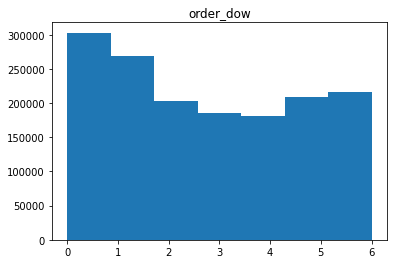

In [ ]:
# 요일별 주문 현황

data['order_dow'].value_counts()

data.hist('order_dow',grid=False, bins=7)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0eeb3c8910>]],
      dtype=object)

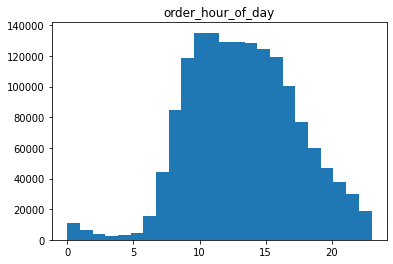

In [ ]:
# 시간대별 주문 현황

data['order_hour_of_day'].value_counts()

data.hist('order_hour_of_day',grid=False, bins=24)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e5008b8d0>]],
      dtype=object)

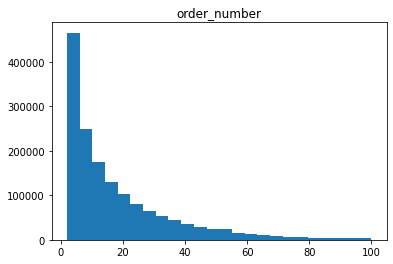

In [ ]:
# 주문 횟수 현황 
data['order_number'].value_counts()

data.hist('order_number',grid=False, bins=24)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e4c2fba50>]],
      dtype=object)

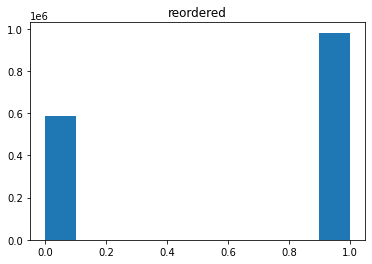

In [ ]:
# 재주문 여부 현황 
data['reordered'].value_counts()

data.hist('reordered',grid=False)

# 3-1) 데이터 전처리(data preprocessing)
## 데이터 Encoding

In [ ]:
data['user_id'] = data['user_id'].astype(int)
data['product_id'] = data['product_id'].astype(int)
data['order_id'] = data['order_id'].astype(int)
data['days_since_prior_order'] = data['days_since_prior_order'].astype(int)

data = data.set_index(['user_id']).sort_index()
data = data.reset_index()

In [ ]:
# 유저 인덱스 인코딩
user_ids = data["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
#userencoded2user = {i: x for i, x in enumerate(user_ids)}

# 주문 인덱스 인코딩
order_ids = data["order_id"].unique().tolist()
order2order_encoded = {x: i for i, x in enumerate(order_ids)}
#order_encoded2order = {i: x for i, x in enumerate(order_ids)}

# 상품 인덱스 인코딩
product_ids = data["product_id"].unique().tolist()
product2product_encoded = {x: i for i, x in enumerate(product_ids)}
#product_encoded2product = {i: x for i, x in enumerate(product_ids)}

# 상품 이름 인코딩
pd_name_ids = data["product_name"].unique().tolist()
pd_name2pd_name_encoded = {x: i for i, x in enumerate(pd_name_ids)}
#pd_name_encoded2pd_name = {i: x for i, x in enumerate(pd_name_ids)}

# 상품 대분류 인덱스 인코딩
department_ids = data["Category_no"].unique().tolist()
department2department_encoded = {x: i for i, x in enumerate(department_ids)}
#department_encoded2department = {i: x for i, x in enumerate(department_ids)}

# 상품 소분류 인덱스 인코딩
aisle_ids = data["aisle_id"].unique().tolist()
aisle2aisle_encoded = {x: i for i, x in enumerate(aisle_ids)}
#aisle_encoded2aisle = {i: x for i, x in enumerate(aisle_ids)}

# 상품 대분류명 인덱스 인코딩
dept_name_ids = data["Category_name"].unique().tolist()
dept_name2dept_name_encoded = {x: i for i, x in enumerate(dept_name_ids)}
#dept_name_encoded2dept_name = {i: x for i, x in enumerate(dept_name_ids)}

# 상품 소분류명 인덱스 인코딩
aisle_name_ids = data["aisle"].unique().tolist()
aisle_name2aisle_name_encoded = {x: i for i, x in enumerate(aisle_name_ids)}
#aisle_name_encoded2aisle_name = {i: x for i, x in enumerate(aisle_name_ids)}

In [ ]:
# 인코딩으로 바꾸기
data["user"] = data["user_id"].map(user2user_encoded)
data["product"] = data["product_id"].map(product2product_encoded)
data["order"] = data["order_id"].map(order2order_encoded)
data["pd_name"] = data["product_name"].map(pd_name2pd_name_encoded)

# data["department"] = data["department_id"].map(department2department_encoded)
# data["aisle"] = data["aisle"].map(aisle2aisle_encoded)
# data["dept_name"] = data["department"].map(dept_name2dept_name_encoded)
# data["aisle_name"] = data["aisle"].map(aisle_name2aisle_name_encoded)

# User기준으로 데이터 조정(feature engineering)
- 구매자 기준으로 데이터프레임 재생성
- feature engineering 추가 가능

In [ ]:
order_hist = data.groupby(['user'])['order_id'].unique().apply(list).reset_index()
product_hist = data.groupby(['user'])['product_id'].apply(list).reset_index()
order_dow_hist = data.groupby(['user'])['order_dow'].apply(list).reset_index() # unique().적용해보기
order_hour_of_day_hist = data.groupby(['user'])['order_hour_of_day'].apply(list).reset_index()
days_since_prior_order_hist = data.groupby(['user'])['days_since_prior_order'].apply(list).reset_index()

In [ ]:
data.groupby(['user'])['order_dow'].unique().apply(list)

user
0                      [5, 6]
1             [1, 2, 3, 5, 4]
2             [4, 6, 0, 1, 2]
3       [0, 4, 1, 6, 2, 5, 3]
4                [4, 5, 2, 1]
                ...          
9995    [0, 2, 3, 5, 1, 6, 4]
9996       [2, 4, 3, 1, 5, 6]
9997                [0, 6, 5]
9998    [0, 1, 2, 4, 6, 3, 5]
9999          [3, 2, 1, 5, 4]
Name: order_dow, Length: 10000, dtype: object

In [ ]:
order_product_hist = data.groupby(['order'])['product_id'].apply(list).reset_index()

In [ ]:
order_hist # 사용자의 주문목록

,user,order_id
0,0,"[3166874, 2766710, 501067, 1643524, 1657641, 7..."
1,1,"[1318871, 1261384, 2100631, 580568, 1680554, 2..."
2,2,"[964058, 2163945, 3349827, 1376443, 2655621, 1..."
3,3,"[2568280, 1763414, 3092533, 414538, 1538989, 3..."
4,4,"[251784, 3211781, 1469604, 1515062, 1342998, 2..."
...,...,...
9995,9995,"[1911923, 549547, 3130715, 2582484, 1258873, 2..."
9996,9996,"[992039, 2551929, 1053779, 2760916, 1877978, 1..."
9997,9997,"[2822394, 83431, 56199, 1597643, 1782820]"
9998,9998,"[3115357, 1209728, 164466, 3304125, 1983173, 1..."


In [ ]:
# 최다(빈도) 구매자의 주문 수(heavy user)

max([x for x in order_hist['order_id'].apply(len)])

99

In [ ]:
product_hist # 사용자가 구매한 상품

,user,product_id
0,0,"[45007, 22613, 28842, 21405, 26209, 19508, 248..."
1,1,"[12341, 6184, 10441, 46149, 196, 14309, 46149,..."
2,2,"[49075, 39121, 21724, 48017, 36695, 28289, 391..."
3,3,"[34213, 34574, 7029, 25305, 41950, 31338, 4235..."
4,4,"[2186, 42699, 25753, 46496, 42139, 24157, 2415..."
...,...,...
9995,9995,"[20512, 18918, 17948, 24489, 13176, 19057, 817..."
9996,9996,"[12099, 40706, 43129, 48119, 8523, 7192, 35761..."
9997,9997,"[24852, 24710, 27307, 32642, 20919, 12508, 267..."
9998,9998,"[23650, 26165, 11087, 48775, 36305, 47977, 428..."


In [ ]:
order_product_hist

,order,product_id
0,0,"[45007, 22613, 28842, 21405, 26209, 19508, 248..."
1,1,"[45007, 36695, 21405, 20339, 24830, 26209, 182..."
2,2,"[45007, 20339, 26209, 43662, 28842, 8057, 4399..."
3,3,"[47823, 20339, 4455, 26298, 17284, 4855, 45007..."
4,4,"[43662, 35855, 5621, 33000, 34012, 24940, 4455..."
...,...,...
155574,155574,"[49273, 34134, 35206, 35473, 10673]"
155575,155575,"[6052, 1716, 49296, 31268, 41673, 48337, 47167..."
155576,155576,"[4978, 24613, 1716, 6052, 49296]"
155577,155577,"[27966, 49273, 49296, 35206, 48337, 7658, 4015..."


In [ ]:
# 주문 당 가장 많은 제품을 구입한 경우
max([x for x in order_product_hist['product_id'].apply(len)])

145

In [ ]:
order_dow_hist

,user,order_dow
0,0,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, ..."
1,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,2,"[4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, ..."
4,4,"[4, 4, 4, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
...,...,...
9995,9995,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9996,9996,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, ..."
9997,9997,"[0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, ..."
9998,9998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
order_hour_of_day_hist

,user,order_hour_of_day
0,0,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1..."
1,1,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1..."
2,2,"[10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 1..."
3,3,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 14, 14, 14, 14, 14..."
4,4,"[14, 14, 14, 14, 14, 14, 18, 18, 18, 18, 18, 1..."
...,...,...
9995,9995,"[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1..."
9996,9996,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1..."
9997,9997,"[19, 19, 19, 19, 19, 19, 19, 19, 21, 21, 21, 2..."
9998,9998,"[14, 14, 14, 14, 14, 14, 14, 14, 14, 9, 9, 9, ..."


In [ ]:
days_since_prior_order_hist

,user,days_since_prior_order
0,0,"[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 2..."
1,1,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ..."
2,2,"[10, 10, 10, 10, 10, 10, 30, 30, 30, 30, 30, 3..."
3,3,"[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1..."
4,4,"[8, 8, 8, 30, 30, 30, 20, 20, 20, 20, 20, 20, ..."
...,...,...
9995,9995,"[22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 2..."
9996,9996,"[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1..."
9997,9997,"[18, 18, 18, 18, 18, 18, 18, 18, 30, 30, 30, 3..."
9998,9998,"[28, 28, 28, 28, 28, 28, 28, 28, 28, 30, 30, 3..."


In [ ]:
# User dataset 생성 (학습에 사용할 데이터, prior order:[data['eval_set']=='prior'])
user_data = data[['user','user_id']].merge(order_hist, how='left').merge(product_hist, how='left').merge(order_dow_hist, how='left').merge(order_hour_of_day_hist, how = 'left').merge(days_since_prior_order_hist,how='left') #eval_set
user_data

,user,user_id,order_id,product_id,order_dow,order_hour_of_day,days_since_prior_order
0,0,48,"[3166874, 2766710, 501067, 1643524, 1657641, 7...","[45007, 22613, 28842, 21405, 26209, 19508, 248...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, ...","[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 2..."
1,0,48,"[3166874, 2766710, 501067, 1643524, 1657641, 7...","[45007, 22613, 28842, 21405, 26209, 19508, 248...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, ...","[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 2..."
2,0,48,"[3166874, 2766710, 501067, 1643524, 1657641, 7...","[45007, 22613, 28842, 21405, 26209, 19508, 248...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, ...","[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 2..."
3,0,48,"[3166874, 2766710, 501067, 1643524, 1657641, 7...","[45007, 22613, 28842, 21405, 26209, 19508, 248...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, ...","[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 2..."
4,0,48,"[3166874, 2766710, 501067, 1643524, 1657641, 7...","[45007, 22613, 28842, 21405, 26209, 19508, 248...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, ...","[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 2..."
...,...,...,...,...,...,...,...
1566105,9999,206185,"[2275747, 1597200, 497488, 1874713, 1286942, 1...","[30217, 35473, 25915, 14852, 15829, 24613, 399...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, ...","[26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 3..."
1566106,9999,206185,"[2275747, 1597200, 497488, 1874713, 1286942, 1...","[30217, 35473, 25915, 14852, 15829, 24613, 399...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, ...","[26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 3..."
1566107,9999,206185,"[2275747, 1597200, 497488, 1874713, 1286942, 1...","[30217, 35473, 25915, 14852, 15829, 24613, 399...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, ...","[26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 3..."
1566108,9999,206185,"[2275747, 1597200, 497488, 1874713, 1286942, 1...","[30217, 35473, 25915, 14852, 15829, 24613, 399...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, ...","[26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 3..."


In [ ]:
user_data = user_data.drop_duplicates('user') # 중복데이터 삭제
user_data.shape

(10000, 7)

In [ ]:
data_product_prior=data['product'][data['eval_set']=='prior']

# predict_label 생성 및 데이터 분할

In [ ]:
user_data['predict_labels'] = user_data['product_id'].apply(lambda x: int(random.uniform(0,data['product_id'].max())))
#user_data['predict_labels'] = user_data['product_id'].apply(lambda x: int(random.uniform(0,data['product'].max())))
# (random.uniform(0,data["product"][data['eval_set']=='prior'].max())) train 데이터의 product중 하나 (=> 알맞은 데이터가 들어가는지 코드 검증 필요)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
user_data

,user,user_id,order_id,product_id,order_dow,order_hour_of_day,days_since_prior_order,predict_labels
0,0,48,"[3166874, 2766710, 501067, 1643524, 1657641, 7...","[45007, 22613, 28842, 21405, 26209, 19508, 248...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, ...","[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 2...",28640
124,1,52,"[1318871, 1261384, 2100631, 580568, 1680554, 2...","[12341, 6184, 10441, 46149, 196, 14309, 46149,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...",47853
298,2,62,"[964058, 2163945, 3349827, 1376443, 2655621, 1...","[49075, 39121, 21724, 48017, 36695, 28289, 391...","[4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 1...","[10, 10, 10, 10, 10, 10, 30, 30, 30, 30, 30, 3...",48619
393,3,63,"[2568280, 1763414, 3092533, 414538, 1538989, 3...","[34213, 34574, 7029, 25305, 41950, 31338, 4235...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, ...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 14, 14, 14, 14, 14...","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...",26678
895,4,83,"[251784, 3211781, 1469604, 1515062, 1342998, 2...","[2186, 42699, 25753, 46496, 42139, 24157, 2415...","[4, 4, 4, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[14, 14, 14, 14, 14, 14, 18, 18, 18, 18, 18, 1...","[8, 8, 8, 30, 30, 30, 20, 20, 20, 20, 20, 20, ...",19366
...,...,...,...,...,...,...,...,...
1564717,9995,206104,"[1911923, 549547, 3130715, 2582484, 1258873, 2...","[20512, 18918, 17948, 24489, 13176, 19057, 817...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 2...",36353
1565137,9996,206123,"[992039, 2551929, 1053779, 2760916, 1877978, 1...","[12099, 40706, 43129, 48119, 8523, 7192, 35761...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, ...","[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...",29010
1565463,9997,206144,"[2822394, 83431, 56199, 1597643, 1782820]","[24852, 24710, 27307, 32642, 20919, 12508, 267...","[0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, ...","[19, 19, 19, 19, 19, 19, 19, 19, 21, 21, 21, 2...","[18, 18, 18, 18, 18, 18, 18, 18, 30, 30, 30, 3...",37642
1565511,9998,206174,"[3115357, 1209728, 164466, 3304125, 1983173, 1...","[23650, 26165, 11087, 48775, 36305, 47977, 428...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 9, 9, 9, ...","[28, 28, 28, 28, 28, 28, 28, 28, 28, 30, 30, 3...",11406


In [ ]:
train_data = user_data[(user_data.user>=30) &
                       (user_data.user<=39)]
test_data = user_data[(user_data.user>=40) &
                      (user_data.user<=59)]

# 모델

In [ ]:
data["product_id"].max()

49687

In [ ]:
data["product"].max()

35053

In [ ]:
# 하이퍼파라미터 정의

EMBEDDING_DIMS = 16
DENSE_UNITS = 64
DROPOUT_PCT = 0.1
ALPHA = 0.1
NUM_CLASSES = data["product_id"].max() + 2 
LEARNING_RATE = 0.1

In [ ]:
# custom layers

import tensorflow as tf
class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
        masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}
    
class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask

In [ ]:
# modeling
import tensorflow as tf
import datetime
import os

input_user = tf.keras.Input(shape=(None, ), name='user') 
input_product_hist = tf.keras.layers.Input(shape=(None,), name='product_hist')
input_order_dow_hist = tf.keras.layers.Input(shape=(None,), name='order_dow_hist')
input_order_hour_of_day_hist = tf.keras.Input(shape=(None, ), name='order_hour_of_day_hist')
input_days_since_prior_order_hist = tf.keras.Input(shape=(None, ), name='days_since_prior_order_hist')


# layer 구성
features_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='features_embeddings')
labels_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='labels_embeddings')

avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

dense_1 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_1')
dense_2 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_2')
dense_3 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_3')
l2_norm_1 = L2NormLayer(name='l2_norm_1')
dense_output = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax, name='dense_output')

# feature 투입
features_embeddings = features_embedding_layer(input_user)
l2_norm_features = l2_norm_1(features_embeddings)
avg_features = avg_embeddings(l2_norm_features)

labels_product_embeddings = labels_embedding_layer(input_product_hist)
l2_norm_product = l2_norm_1(labels_product_embeddings)
avg_product = avg_embeddings(l2_norm_product)

labels_order_dow_embeddings = labels_embedding_layer(input_order_dow_hist)
l2_norm_order_dow = l2_norm_1(labels_order_dow_embeddings)
avg_order_dow = avg_embeddings(l2_norm_order_dow)

labels_order_hour_embeddings = labels_embedding_layer(input_order_hour_of_day_hist)
l2_norm_order_hour = l2_norm_1(labels_order_hour_embeddings)
avg_order_hour = avg_embeddings(l2_norm_order_hour)

labels_since_prior_embeddings = labels_embedding_layer(input_days_since_prior_order_hist)
l2_norm_since_prior = l2_norm_1(labels_since_prior_embeddings)
avg_since_prior = avg_embeddings(l2_norm_since_prior)


print(avg_features)
print(avg_order_dow)
print(avg_order_hour)
print(avg_since_prior)

# 임베딩 벡터들 연결
concat_inputs = tf.keras.layers.Concatenate(axis=1)([avg_product,
                                                     avg_order_dow, 
                                                     avg_order_hour,
                                                     avg_since_prior
                                                     ])
# Dense Layers
dense_1_features = dense_1(concat_inputs)
dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

dense_2_features = dense_2(dense_1_relu)
dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
dense_2_batch_norm = tf.keras.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

dense_3_features = dense_3(dense_2_relu)
dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
dense_3_batch_norm = tf.keras.layers.BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)

outputs = dense_output(dense_3_batch_norm)

#Optimizer
optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

#--- prep model
model = tf.keras.models.Model(
    inputs=[input_product_hist,
            input_order_dow_hist,
            input_order_hour_of_day_hist,
            input_days_since_prior_order_hist
            ],
    outputs=[outputs]
)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['acc']) 

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='aggregate_embeddings/PartitionedCall:0', description="created by layer 'aggregate_embeddings'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='aggregate_embeddings/PartitionedCall:0', description="created by layer 'aggregate_embeddings'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='aggregate_embeddings/PartitionedCall:0', description="created by layer 'aggregate_embeddings'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='aggregate_embeddings/PartitionedCall:0', description="created by layer 'aggregate_embeddings'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 product_hist (InputLayer)      [(None, None)]       

In [ ]:
train_data

,user,user_id,order_id,product_id,order_dow,order_hour_of_day,days_since_prior_order,predict_labels
5193,30,486,"[2505013, 1859176, 578638, 2453743, 1675581, 1...","[31066, 11520, 29307, 38051, 30489, 39922, 137...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",28979
5482,31,491,"[1329272, 2065829, 1191993]","[4853, 20114, 35376, 13176, 19057, 49683, 7175...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, ...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...","[22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 2...",25251
5514,32,523,"[2324216, 2823017, 1179143, 2504221, 2406452, ...","[21694, 12831, 46364, 21694, 27086, 5785, 2485...","[5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[15, 15, 15, 16, 16, 16, 16, 11, 11, 11, 11, 1...","[16, 16, 16, 24, 24, 24, 24, 30, 30, 30, 30, 3...",12382
5565,33,538,"[3115305, 2311352, 2336727, 556480, 1392748, 2...","[48364, 24184, 7664, 44457, 36849, 44245, 2803...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 16, 16, 16, ...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",30245
5800,34,558,"[2352353, 2996263, 2792437, 1551696, 542577, 1...","[13740, 5194, 1511, 12813, 33572, 16994, 16254...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1...","[1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, ...",38130
6108,35,559,"[388961, 980993, 1517965, 1521472, 2180413, 31...","[44628, 5991, 47734, 24489, 24964, 32689, 3412...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",29049
6349,36,562,"[912968, 2829143, 2680210, 975257, 2211584, 12...","[38928, 15541, 38928, 38928, 38928, 38928, 167...","[5, 5, 2, 5, 2, 3, 3, 5, 3, 3, 2, 2, 4, 2, 2, ...","[12, 12, 11, 11, 11, 9, 9, 14, 7, 9, 9, 8, 9, ...","[3, 3, 11, 3, 4, 8, 8, 2, 5, 7, 6, 7, 2, 5, 5,...",39861
6412,37,577,"[2944620, 994838, 1002626, 148818, 1241717]","[30974, 20406, 10243, 22922, 31553, 28842, 310...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 2...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",2747
6483,38,614,"[2851369, 2051249, 2558969]","[13176, 26131, 47912, 8490, 6933, 4210, 16349,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1, ...","[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 20, 2...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",31212
6502,39,620,"[2536785, 2461157, 1806302, 1048253, 416736]","[12448, 36534, 13948, 12448, 36534, 36534, 139...","[3, 3, 3, 5, 5, 4, 4, 4, 4, 4, 4]","[18, 18, 18, 13, 13, 17, 17, 10, 10, 18, 18]","[30, 30, 30, 30, 30, 30, 30, 28, 28, 30, 30]",30464


In [ ]:
# 학습(training)
history = model.fit([tf.keras.preprocessing.sequence.pad_sequences(train_data['product_id']),
                     tf.keras.preprocessing.sequence.pad_sequences(train_data['order_dow']),
                     tf.keras.preprocessing.sequence.pad_sequences(train_data['order_hour_of_day']), #+ 1e-10, dtype=float
                     tf.keras.preprocessing.sequence.pad_sequences(train_data['days_since_prior_order'])
                    ],train_data['predict_labels'].values,
                  #batch_size=16,
                  steps_per_epoch=1, epochs=300)

Epoch 1/300
1/1 [==============================] - 1s 1s/step - loss: 10.8200 - acc: 0.0000e+00
Epoch 2/300
1/1 [==============================] - 0s 35ms/step - loss: 10.5634 - acc: 0.2000
Epoch 3/300
1/1 [==============================] - 0s 26ms/step - loss: 9.2712 - acc: 0.2000
Epoch 4/300
1/1 [==============================] - 0s 27ms/step - loss: 5.7971 - acc: 0.5000
Epoch 5/300
1/1 [==============================] - 0s 24ms/step - loss: 4.1515 - acc: 0.3000
Epoch 6/300
1/1 [==============================] - 0s 28ms/step - loss: 2.4918 - acc: 0.6000
Epoch 7/300
1/1 [==============================] - 0s 24ms/step - loss: 1.9895 - acc: 0.4000
Epoch 8/300
1/1 [==============================] - 0s 26ms/step - loss: 2.0497 - acc: 0.4000
Epoch 9/300
1/1 [==============================] - 0s 30ms/step - loss: 1.3786 - acc: 0.5000
Epoch 10/300
1/1 [==============================] - 0s 24ms/step - loss: 1.2415 - acc: 0.4000
Epoch 11/300
1/1 [==============================] - 0s 27ms/step 

In [ ]:
# 모델 저장
model.save("/content/drive/MyDrive/마켓컬리/model_2.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# 모델 예측결과 추출
pred = model.predict([tf.keras.preprocessing.sequence.pad_sequences(test_data['product_id']),
           tf.keras.preprocessing.sequence.pad_sequences(test_data['order_dow']),
           tf.keras.preprocessing.sequence.pad_sequences(test_data['order_hour_of_day']), #+ 1e-10, dtype=float
           tf.keras.preprocessing.sequence.pad_sequences(test_data['days_since_prior_order'])
           ])

pred

array([[3.6155363e-08, 5.0317059e-08, 4.0390422e-08, ..., 3.4842639e-08,
        5.6324005e-08, 4.6804679e-08],
       [2.5067657e-09, 3.6271071e-09, 2.8354605e-09, ..., 2.3000657e-09,
        3.4933680e-09, 3.4364873e-09],
       [2.5067657e-09, 3.6271071e-09, 2.8354605e-09, ..., 2.3000657e-09,
        3.4933680e-09, 3.4364873e-09],
       ...,
       [2.5067657e-09, 3.6271071e-09, 2.8354605e-09, ..., 2.3000657e-09,
        3.4933680e-09, 3.4364873e-09],
       [2.5067657e-09, 3.6271071e-09, 2.8354605e-09, ..., 2.3000657e-09,
        3.4933680e-09, 3.4364873e-09],
       [2.5067657e-09, 3.6271071e-09, 2.8354605e-09, ..., 2.3000657e-09,
        3.4933680e-09, 3.4364873e-09]], dtype=float32)

In [ ]:
# candidate generation: 
###### 각 user당 top-7개의 추천 후보 데이터(predict_label)를 뽑아낸다.
import numpy as np
N = 20
k = np.sort((-pred).argsort()[:,:N])
print(k)
k = k.flatten()
k[k>data["product"].max()]=0
k = np.unique(k)

[[ 2747  3773  8099 12382 16293 20570 22788 25251 27525 28979 30245 30464
  31212 31403 35940 38130 39861 44919 45819 48874]
 [ 2240  2747  3773 12382 14759 16293 22788 25251 27525 28979 29049 30245
  30464 31212 31403 35940 38130 39861 44919 48874]
 [ 2240  2747  3773 12382 14759 16293 22788 25251 27525 28979 29049 30245
  30464 31212 31403 35940 38130 39861 44919 48874]
 [ 2240  2747  3773 12382 14759 16293 22788 25251 27525 28979 29049 30245
  30464 31212 31403 35940 38130 39861 44919 48874]
 [ 2240  2747  3773 12382 14759 16293 22788 25251 27525 28979 29049 30245
  30464 31212 31403 35940 38130 39861 44919 48874]
 [ 2240  2747  3773 12382 14759 16293 22788 25251 27525 28979 29049 30245
  30464 31212 31403 35940 38130 39861 44919 48874]
 [ 2240  2747  3773 12382 14759 16293 22788 25251 27525 28979 29049 30245
  30464 31212 31403 35940 38130 39861 44919 48874]
 [ 2240  2747  3773 12382 14759 16293 22788 25251 27525 28979 29049 30245
  30464 31212 31403 35940 38130 39861 44919 48874]


In [ ]:
k[2]

1959

In [ ]:
# load candidate_generation 
model = tf.keras.models.load_model(
    '/content/drive/MyDrive/마켓컬리/model_2.h5',
    custom_objects={
        'L2NormLayer':L2NormLayer,
        'MaskedEmbeddingsAggregatorLayer':MaskedEmbeddingsAggregatorLayer
    }
)

In [ ]:
aisles = pd.read_csv('/content/drive/MyDrive/2022 마켓컬리 해커톤/Data/aisles.csv')
products = pd.read_csv('/content/drive/MyDrive/2022 마켓컬리 해커톤/Data/product_final.csv')
products = products.merge(aisles, how='left', on= 'aisle_id')
products.head(3)

,Unnamed: 0,product_id,product_name,aisle_id,Category_no,Category_name,standard_price(won),price(won),Only_kurly,discount(%),No_of_reviews,Monthly_Avg_Sales_Qty,aisle
0,0,1,Chocolate Sandwich Cookies,61,19,snacks,6900,4625,1,32.97,0,755.9,cookies cakes
1,1,2,All-Seasons Salt,104,13,pantry,29800,27150,1,8.89,416,3509.5,spices seasonings
2,2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,16100,8927,0,44.55,173,2906.3,tea


In [ ]:
products.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
product_enc = pd.get_dummies(products, columns=['aisle'], prefix=[None])
product_enc

# 아이템의 속성(ex.aisle)을 불러오는 함수 
aisle_cols = aisles['aisle'].values.tolist()
# type(aisle_cols)
aisle_cols
aisles_encoded = {x: i for i, x in enumerate(aisle_cols)}

# product_ids = products["product_id"].unique().tolist()
# # product_enc = {x: i for i, x in enumerate(product_ids)}
# # product_enc
# products.drop('Unnamed: 0', axis=1, inplace=True)
# products.head(3)
# product_enc = products

# movies-> product_enc
# genres-> aisles
# aisles -> ['a', 'b', 'c', ...]

def get_aisles(products, aisles):
	def get_all_aisles(ai):
		active = [str(aisles_encoded[aisle]) for aisle, a in zip(aisles, ai) if a==1]
		if len(active) == 0:
			return '0'
		return ','.join((active))
	
	products['all_aisles'] = [
                            get_all_aisles(ai) for ai in zip(*[products[aisle] for aisle in aisles])
                            ]

get_aisles(product_enc, aisle_cols)

In [ ]:
data['reordered'].value_counts()

1    981131
0    584979
Name: reordered, dtype: int64

In [ ]:
ratings = data[['product_id', 'reordered']]
ratings

,product_id,reordered
0,45007,0
1,22613,0
2,28842,0
3,21405,0
4,26209,0
...,...,...
1566105,24097,0
1566106,14852,1
1566107,27061,0
1566108,19627,0


In [ ]:
# normalize
def normalize_col(df,col_name):
    df[col_name] = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
    return df

In [ ]:
product_data = product_enc.set_index(['product_id']).sort_index()

# using candidate result 'k'
product_data = product_data.loc[k+1]
product_data["pd_name_d"] = product_data["product_name"].map(pd_name2pd_name_encoded)
print(product_data.head())

# 레퍼런스와 대조하여 feature 정리: 
 # rating -> reordered (1: like / 0: dislike)
 # unix_timestamp-> order_hour_of_day / 굳이 필요없으면 사용하지 않기. 
ratings_cols = ['user_id', 'product_id', 'reordered', 'order_hour_of_day']
ratings = data[['product_id', 'reordered', 'user_id', 'order_hour_of_day' ]]

# 모델에 사용할 new_data
new_data = product_data.merge(ratings, on='product_id') # rating 추가
print(new_data.columns)

aisle_occurences = new_data[aisle_cols].sum().to_dict()
aisles_encoded = {x: i for i, x in enumerate(aisle_cols)}

get_aisles(product_data, aisle_cols)

                                                 product_name  aisle_id  \
product_id                                                                
1                                  Chocolate Sandwich Cookies        61   
797         Unstopables Downy Unstopables Dreams In-Wash S...        75   
1960                      Nonfat Light & Fit Blueberry Yogurt       120   
2241                               Traditional Ricotta Cheese       108   
2748                         Organic Reduced Fat Omega-3 Milk        84   

            Category_no Category_name  standard_price(won)  price(won)  \
product_id                                                               
1                    19        snacks                 6900        4625   
797                  17     household                83800       48704   
1960                 16    dairy eggs                11300       10380   
2241                 16    dairy eggs                55700       42337   
2748                 16    dai

In [ ]:
new_data.columns

Index(['product_id', 'product_name', 'aisle_id', 'Category_no',
       'Category_name', 'standard_price(won)', 'price(won)', 'Only_kurly',
       'discount(%)', 'No_of_reviews',
       ...
       'trash bags liners', 'vitamins supplements',
       'water seltzer sparkling water', 'white wines', 'yogurt', 'all_aisles',
       'pd_name_d', 'reordered', 'user_id', 'order_hour_of_day'],
      dtype='object', length=150)

In [ ]:
new_data = new_data[['product_id', 'user_id', 'reordered', 'order_hour_of_day', 'all_aisles', 'pd_name_d']]
new_data['product_type'] = np.where(new_data['reordered'] ==1, 'like', 'dislike') # 1이면 like

product_list = new_data.groupby(['user_id','product_type'])['product_id'].apply(list).reset_index()

aisle_list = new_data.groupby(['user_id'])['all_aisles'].unique().apply(list).reset_index()
aisle_list['all_aisles']=aisle_list['all_aisles'].apply(lambda x: list(set(','.join(x))) ) # 중복제거
aisle_list['all_aisles']=aisle_list['all_aisles'].apply(lambda x:[ x for x in x if x.isdigit() ])
    
# normalize
new_data = normalize_col(new_data, 'order_hour_of_day')
order_hour_of_day_list = new_data.groupby(['user_id'])['order_hour_of_day'].unique().apply(list).reset_index()

pd_name_list = new_data.groupby(['user_id'])['pd_name_d'].apply(list).reset_index()
print(product_list)
dataset = product_list.pivot(index='user_id', columns='product_type', values='product_id').reset_index()
dataset.fillna(new_data["product_id"].max()+1, inplace=True)

dataset['like'] =dataset['like'].apply(lambda x: x if type(x) is list else [])
dataset['dislike'] =dataset['dislike'].apply(lambda x: x if type(x) is list else [])

dataset = pd.merge(dataset, pd_name_list, how='left')
dataset = pd.merge(dataset, aisle_list, how='left')
dataset = pd.merge(dataset, order_hour_of_day_list, how='left')


dataset['predict_labels'] = dataset['like'].apply(lambda x: int(random.uniform(1,new_data["product_id"].max()))) 

dataset['like']=dataset['like'].apply(lambda x: [new_data["product_id"].max()+1] if x == [] else x)
dataset['dislike']=dataset['dislike'].apply(lambda x: [new_data["product_id"].max()+1] if x == [] else x)
# train_data=dataset[(dataset.user_id >= 1)&
#                                   (dataset.user_id <= 5)]
# test_data=dataset[(dataset.user_id >= 6)&
#                                   (dataset.user_id <= 9)]
train_data_r=dataset[(dataset.index >= 0)&
                                  (dataset.index <= 9)]
test_data_r=dataset[(dataset.index >= 20)&
                                  (dataset.index <= 24)]

print(dataset.index)

     user_id product_type                                         product_id
0        409         like  [2748, 2748, 2748, 2748, 2748, 2748, 2748, 274...
1       3214      dislike                                            [14267]
2       3631         like                                             [3774]
3       3939      dislike                                            [21501]
4       3939         like                                     [21501, 21501]
..       ...          ...                                                ...
400   201985         like  [31404, 31404, 31404, 31404, 31404, 31404, 314...
401   203538      dislike                                            [14267]
402   204667      dislike                                            [31404]
403   204858         like                                            [31404]
404   205160      dislike                                            [14267]

[405 rows x 3 columns]
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_data_r

,user_id,dislike,like,pd_name_d,all_aisles,order_hour_of_day,predict_labels
0,409,[31405],"[2748, 2748, 2748, 2748, 2748, 2748, 2748, 274...","[1299.0, 1299.0, 1299.0, 1299.0, 1299.0, 1299....","[3, 8]","[0.5652173913043478, 0.34782608695652173, 0.47...",19485
1,3214,[14267],[31405],[4837.0],"[5, 8]",[0.4782608695652174],24501
2,3631,[31405],[3774],[5157.0],"[6, 1]",[0.6086956521739131],15303
3,3939,[21501],"[21501, 21501]","[5478.0, 5478.0, 5478.0]",[4],"[0.5652173913043478, 0.5217391304347826, 0.391...",24540
4,4280,[14267],[31405],[4837.0],"[5, 8]",[0.43478260869565216],9865
5,5360,[31404],"[31404, 31404, 31404, 31404]","[6534.0, 6534.0, 6534.0, 6534.0, 6534.0]","[1, 9]","[0.391304347826087, 0.4782608695652174, 0.5652...",12339
6,6011,[14267],[31405],[4837.0],"[5, 8]",[0.6086956521739131],9911
7,6569,[2748],"[2748, 2748]","[1299.0, 1299.0, 1299.0]","[3, 8]","[0.9130434782608695, 0.34782608695652173, 0.65...",5161
8,6637,[14267],[31405],[4837.0],"[5, 8]",[0.5217391304347826],14287
9,7103,[31405],[14267],[4837.0],"[5, 8]",[0.43478260869565216],22041


In [ ]:
test_data_r

,user_id,dislike,like,pd_name_d,all_aisles,order_hour_of_day,predict_labels
20,15881,[31404],"[31404, 31404, 31404, 31404, 31404, 31404, 314...","[6534.0, 6534.0, 6534.0, 6534.0, 6534.0, 6534....","[1, 9]","[0.43478260869565216, 0.34782608695652173, 0.3...",28131
21,15989,[1],[31405],[12742.0],"[6, 0]",[0.43478260869565216],560
22,16574,[31405],"[31404, 31404, 31404, 31404, 31404, 31404, 314...","[6534.0, 6534.0, 6534.0, 6534.0, 6534.0, 6534....","[1, 9]","[0.4782608695652174, 0.5217391304347826, 0.608...",3267
23,19287,[14267],[31405],[4837.0],"[5, 8]",[0.5217391304347826],6492
24,20136,[14267],[14267],"[4837.0, 4837.0]","[5, 8]","[0.2608695652173913, 0.9130434782608695]",27570


In [ ]:
EMBEDDING_DIMS = 16
DENSE_UNITS = 64
DROPOUT_PCT = 0.1
ALPHA = 0.0
NUM_CLASSES=new_data["product_id"].max() + 3
LEARNING_RATE = 0.003

In [ ]:
#---inputs
import tensorflow as tf
import datetime
import os
input_name = tf.keras.Input(shape=(None, ), name='product_name')
inp_item_liked = tf.keras.layers.Input(shape=(None,), name='like')
inp_item_disliked = tf.keras.layers.Input(shape=(None,), name='dislike')
input_aisle = tf.keras.Input(shape=(None, ), name='aisle')
input_order_hour = tf.keras.Input(shape=(None, ), name='order_hour')


#--- layers
features_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='features_embeddings')
labels_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='labels_embeddings')

avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

dense_1 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_1')
dense_2 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_2')
dense_3 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_3')
l2_norm_1 = L2NormLayer(name='l2_norm_1')

dense_output = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax, name='dense_output')

#--- features
features_embeddings = features_embedding_layer(input_name)
l2_norm_features = l2_norm_1(features_embeddings)
avg_features = avg_embeddings(l2_norm_features)

labels_liked_embeddings = labels_embedding_layer(inp_item_liked)
l2_norm_liked = l2_norm_1(labels_liked_embeddings)
avg_liked = avg_embeddings(l2_norm_liked)

labels_disliked_embeddings = labels_embedding_layer(inp_item_disliked)
l2_norm_disliked = l2_norm_1(labels_disliked_embeddings)
avg_disliked = avg_embeddings(l2_norm_disliked)

labels_aisle_embeddings = labels_embedding_layer(input_aisle)
l2_norm_aisle = l2_norm_1(labels_aisle_embeddings)
avg_aisle = avg_embeddings(l2_norm_aisle)

labels_order_hour_embeddings = labels_embedding_layer(input_order_hour)
l2_norm_order_hour = l2_norm_1(labels_order_hour_embeddings)
avg_order_hour = avg_embeddings(l2_norm_order_hour)


# 임베딩 벡터들 연결
concat_inputs = tf.keras.layers.Concatenate(axis=1)([avg_features,
                                                     avg_liked,
                                                     avg_disliked,
                                                     avg_aisle,
                                                     avg_order_hour
                                                     ])
# Dense Layers
dense_1_features = dense_1(concat_inputs)
dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

dense_2_features = dense_2(dense_1_relu)
dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
# dense_2_batch_norm = tf.keras.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

dense_3_features = dense_3(dense_2_relu)
dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
dense_3_batch_norm = tf.keras.layers.BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)
outputs = dense_output(dense_3_batch_norm)

#Optimizer
optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

#--- prep model
model = tf.keras.models.Model(
    inputs=[input_name, 
            inp_item_liked, 
            inp_item_disliked,
            input_aisle,
            input_order_hour,
            ],
    outputs=[outputs]
)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 product_name (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 like (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 dislike (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 aisle (InputLayer)             [(None, None)]       0           []                               
                                                                                            

In [ ]:
ratings1 = model.fit([tf.keras.preprocessing.sequence.pad_sequences(train_data_r['pd_name_d'])+ 1e-10,
           tf.keras.preprocessing.sequence.pad_sequences(train_data_r['like'])+ 1e-10,
           tf.keras.preprocessing.sequence.pad_sequences(train_data_r['dislike'])+ 1e-10,
            tf.keras.preprocessing.sequence.pad_sequences(train_data_r['all_aisles'])+ 1e-10,
            tf.keras.preprocessing.sequence.pad_sequences(train_data_r['order_hour_of_day'], dtype=float) + 1e-10,
           ],train_data_r['predict_labels'].values,
           steps_per_epoch=1, epochs=300)

Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 10.3532 - acc: 0.0000e+00
Epoch 2/300
1/1 [==============================] - 0s 23ms/step - loss: 10.2054 - acc: 0.5000
Epoch 3/300
1/1 [==============================] - 0s 22ms/step - loss: 10.0832 - acc: 0.7000
Epoch 4/300
1/1 [==============================] - 0s 21ms/step - loss: 9.9540 - acc: 0.7000
Epoch 5/300
1/1 [==============================] - 0s 21ms/step - loss: 9.8183 - acc: 0.7000
Epoch 6/300
1/1 [==============================] - 0s 27ms/step - loss: 9.6794 - acc: 0.7000
Epoch 7/300
1/1 [==============================] - 0s 25ms/step - loss: 9.5366 - acc: 0.7000
Epoch 8/300
1/1 [==============================] - 0s 25ms/step - loss: 9.3913 - acc: 0.7000
Epoch 9/300
1/1 [==============================] - 0s 21ms/step - loss: 9.2422 - acc: 0.7000
Epoch 10/300
1/1 [==============================] - 0s 22ms/step - loss: 9.0895 - acc: 0.7000
Epoch 11/300
1/1 [==============================] - 0s 26ms/step

In [ ]:
model.save("/content/drive/MyDrive/2022 마켓컬리 해커톤/ranked_candiates.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# prediction 
pred_1 = model.predict([tf.keras.preprocessing.sequence.pad_sequences(test_data_r['pd_name_d'])+ 1e-10,
           tf.keras.preprocessing.sequence.pad_sequences(test_data_r['like'])+ 1e-10,
           tf.keras.preprocessing.sequence.pad_sequences(test_data_r['dislike'])+ 1e-10,
            tf.keras.preprocessing.sequence.pad_sequences(test_data_r['all_aisles'])+ 1e-10,
            tf.keras.preprocessing.sequence.pad_sequences(test_data_r['order_hour_of_day'], dtype=float) + 1e-10
           ])

pred_1

array([[2.6896669e-07, 2.5756270e-07, 2.5857051e-07, ..., 2.5636288e-07,
        2.5814057e-07, 2.5692339e-07],
       [6.8240010e-06, 6.3870552e-06, 6.5691456e-06, ..., 6.6388520e-06,
        6.6520788e-06, 6.5456447e-06],
       [1.2716650e-06, 1.2009275e-06, 1.1792448e-06, ..., 1.1943100e-06,
        1.2291558e-06, 1.1817735e-06],
       [8.5774431e-08, 7.9063049e-08, 8.1878149e-08, ..., 8.0879261e-08,
        8.1439396e-08, 8.0709206e-08],
       [1.0017782e-07, 9.2189957e-08, 9.5467620e-08, ..., 9.4394728e-08,
        9.5100503e-08, 9.4071474e-08]], dtype=float32)

In [ ]:
# ranking
###### 각 user당 top-20개의 추천 데이터를 뽑아낸다.
N = 20
# k = np.sort((-pred_1).argsort()[:,:N]) 
# np.argsort(): probability의 마이너스값을 작은 값부터 순서대로 데이터의 인덱스를 반환. ==> 즉, 양의값으로는 큰 값부터 반환한 셈.
# np.sort(): 인덱스 순으로 다시 정렬. 확률이 더 높은 것부터 보고싶으므로 레퍼런스에 있는 코드이지만 사용하지 않음. 

ranking_1 = (-pred_1).argsort()[:, :N]
ranking_1[ranking_1>new_data['product_id'].max()]=0 

print(ranking_1)

[[12339 15303 19485 24540  5161 21533  7211  9114 12717 14608 26874 24369
  18218 19823 10155 18264  2596 26150 18828 30744]
 [15303 24540 12339 19485 22041 24929 13981 29706 24183 21533 13314 18218
  26874 16850 17029 29793 26150 30744 25404 31177]
 [15303 12339 19485 24540 22041  9114  7211 18218 21533  9424 12717 29706
  11865 11582 17259 13836 18828 28385 24369 27910]
 [14287 24501  9865  9911  5161 24540 18218 17259 24818 13506 29706 13371
  17050 21848  6497 13836 16294 12444  4091 11244]
 [14287 24501  9865  9911  5161 24540 18218 17259 13506 24818 29706 13371
  17050 16294 21848 13836  9582  6497 12444  5851]]


In [ ]:
tmp = pd.DataFrame({'Products':[ranking_1[0], ranking_1[1], ranking_1[2], ranking_1[3], ranking_1[4]]})

tmp.to_csv('/content/drive/MyDrive/2022 마켓컬리 해커톤/5users_recommendations.csv', encoding='utf-8-sig')

In [ ]:
tmp

,Products
0,"[12339, 15303, 19485, 24540, 5161, 21533, 7211..."
1,"[15303, 24540, 12339, 19485, 22041, 24929, 139..."
2,"[15303, 12339, 19485, 24540, 22041, 9114, 7211..."
3,"[14287, 24501, 9865, 9911, 5161, 24540, 18218,..."
4,"[14287, 24501, 9865, 9911, 5161, 24540, 18218,..."
